# Objectives
Here, our objective is to predict the percentage of electric consumption in the period between 2017-01-01 and 2018-01-01 in India by using the past data from 1985-01-01 to 2016-12-01. 

In these days, more and more time series data is being generated and we are required to get insights from these data. From Marketing, IoT, Health to Finance, Information security, time series data appears almost every situation. In TSA, in addition to traditional statistical methods, there emerge so many fancy techniques. Especially, `prophet` is easy to manipulate even for non-tech guys. Here, I compare new techniques for TSA and share my knowledge about them.

Concletely, if we can predict the electric consumption effectively in the country, we may prevent short of electricity or adjust the supply.

# Dataset
Electric production in India. The unit is %. 

https://www.kaggle.com/kandij/electric-production

**Datasets** <br>
Overview of Dataset
- Unit of data: Each month
- Range of data: From 1985-01-01 to 2018-01-01 (1 data per month)

Variables
- `DATE`: Year-Month-Day
- `value`: Electric consumption percentage

# Strategy
- Objective: By using data from 1985-01-01 to 2016-12-01, to predict the percentage of electric consumption in  the period between 2017-01-01 and 2018-01-01 in India
- Dependent variables: `value` (generated from the variable STATUS)
- Independent variables: own past values
- Time Series models: prophet, SNN, DNN, CNN, RNN, LSTM 

# Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

# pystan & prophet
import pystan
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

import tensorflow as tf
print(tf.__version__)

import warnings
warnings.simplefilter('ignore')

path="/content/drive/My Drive/yuzy_portfolio/yuzy_portfolio/Machine_Learning/data"

2.3.0


# Defined Functions

In [2]:
# Plot time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# Check the data

## `.read_csv()`

- `DATE`、lagged values `Value`
- When we use `prophet`, the date column should be `ds`, the value column should be `y`.<br>
- To change the columns names, take the arguments of `names=["ds", "y"],header=0` in `read_csv()`. 
- Don't set the date column as an index. 
- `parse_dates` make the column `datetime` type.

In [3]:
df = pd.read_csv(path+'/01_raw/Electric_Production.csv', names=["ds", "y"], header=0, parse_dates = ['ds'])
# df = pd.read_csv("Electric_Production.csv", names=["ds", "y"],header=0, parse_dates = ['ds'])

## `.head()` `.tail()`

In [4]:
display(df.head(3))
display(df.tail(3))

,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502


,ds,y
394,2017-11-01,97.3359
395,2017-12-01,114.7212
396,2018-01-01,129.4048


Data range is 1985～2018.
The unit of data is monthly.

## Visualization

At first, see the data.

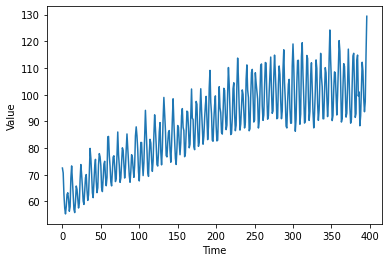

In [5]:
# plot
plot_series(np.arange(len(df)), df["y"].values)

There are about 400 months data.

- Trend is increasing.
- In small periods, there are intervals.

## Missing values

In [6]:
df.isnull().sum()

ds    0
y     0
dtype: int64

There is no need to do pre-processing. So, let's move on modeling.

In [7]:
df.to_pickle(path+"/03_primary/mastertable_india_electricity.pickle")

# Split the data

In [8]:
time = df["ds"].values
series = df["y"].values
split_time = len(df.set_index("ds")["1985-01-01": "2012-12-31"])

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

split_time

336

# Time Series Forecasting

## Prophet

About `prophet`

prophet References: https://facebook.github.io/prophet/docs/quick_start.html <br>
Github: https://github.com/facebook/prophet <br>

Let's execute the code on google colab due to the easiness of developing the environment.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


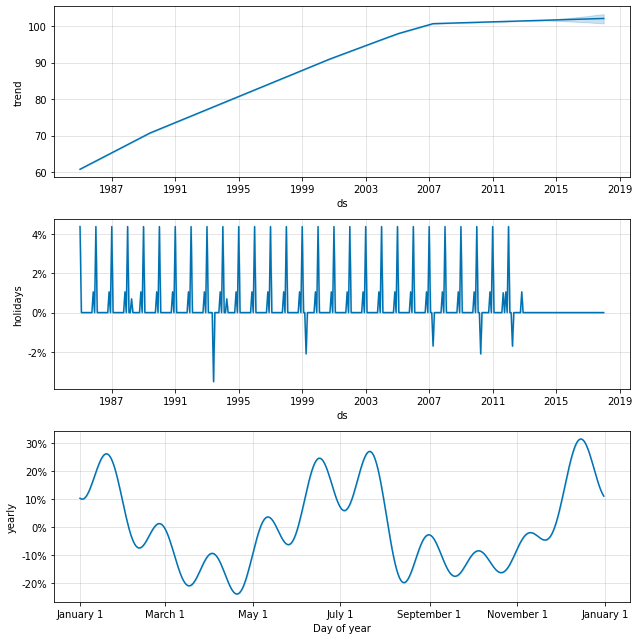

In [9]:
# Build the prediction model
prophet_model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10,
                seasonality_mode='multiplicative')
  # Add the info of official holidays in India
prophet_model.add_country_holidays(country_name='IN')

# Fit the model to the data
prophet_fitted = prophet_model.fit(df[:split_time])

# monthly data takes periods=37, freq='M' here.
prophet_future = prophet_model.make_future_dataframe(periods=len(x_valid), freq='M')

# Predict the future values
prophet_forecast = prophet_fitted.predict(prophet_future)

# Visualize the components
fig = prophet_model.plot_components(prophet_forecast)

3.3152522982760444

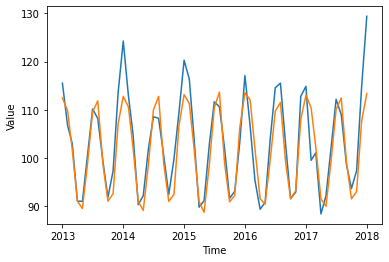

In [10]:
# Evaluate the accuracy of this demonstration
# Plot the estimated values and actual values     
plot_series(time_valid, df[split_time:]["y"])
plot_series(time_valid, prophet_forecast[split_time:]["yhat"])

prophet_MAE = tf.keras.metrics.mean_absolute_error(df[split_time:]["y"], prophet_forecast[split_time:]["yhat"]).numpy()
prophet_MAE

## Random Forest

## Simple Neural Network

In [11]:
# Set up important factors
window_size = 12
batch_size = 8
shuffle_buffer_size = 100

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Use train data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

# Build the prediction model
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
SNN_model = tf.keras.models.Sequential([l0])
SNN_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

# Fit the model to the data
SNN_model.fit(dataset,epochs=100,verbose=0)
# See the weights 
print("Layer weights {}".format(l0.get_weights()))

# Predict the future values
SNN_forecast = []

for time in range(len(series) - window_size):
  SNN_forecast.append(SNN_model.predict(series[time:time + window_size][np.newaxis]))

SNN_forecast = SNN_forecast[split_time-window_size:]
SNN_results = np.array(SNN_forecast)[:, 0, 0]

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[ 0.47935033],
       [ 0.14150564],
       [-0.12369289],
       [ 0.25801247],
       [-0.25720906],
       [ 0.1324998 ],
       [-0.13978614],
       [ 0.30509713],
       [-0.01351523],
       [-0.22108307],
       [ 0.01557984],
       [ 0.42976645]], dtype=float32), array([0.00619639], dtype=float32)]


3.1922235

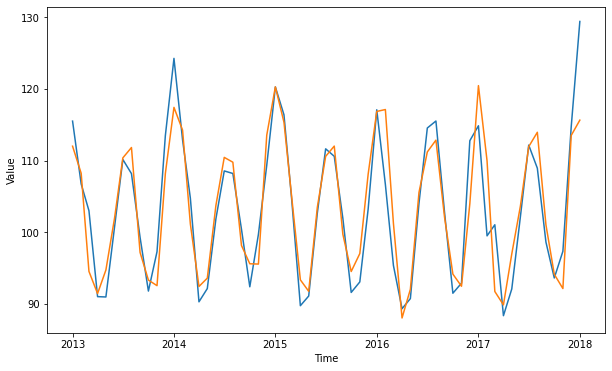

In [12]:
# Plot the comparisons between actual values and estimated values
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, SNN_results)

# Accuracy
SNN_MAE = tf.keras.metrics.mean_absolute_error(x_valid, SNN_results).numpy()
SNN_MAE

## Deep Neural Network

In [13]:
# Set up important factors
window_size = 12
batch_size = 8
shuffle_buffer_size = 100

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Use train data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the prediction model
DNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(150, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(150, activation="relu"), 
    tf.keras.layers.Dense(1)
])

DNN_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, 
                                                             momentum=0.9
                                                             ))

# Fit the model to the data
history = DNN_model.fit(dataset,epochs=200, verbose=0)

# Predict the future values 
DNN_forecast = []
for time in range(len(series) - window_size):
  DNN_forecast.append(DNN_model.predict(series[time:time + window_size][np.newaxis]))

DNN_forecast = DNN_forecast[split_time-window_size:]
DNN_results = np.array(DNN_forecast)[:, 0, 0]

5.1887

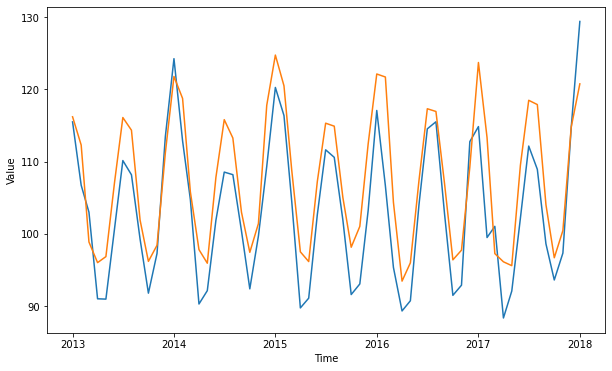

In [14]:
# Plot the comparisons between actual values and estimated values
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, DNN_results)

# Accuracy
DNN_MAE = tf.keras.metrics.mean_absolute_error(x_valid, DNN_results).numpy()
DNN_MAE

## LSTM

In [15]:
# Set up important factors
window_size = 12
batch_size = 8
shuffle_buffer_size = 100

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)



# Use train data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the prediction model
LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
LSTM_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model to the data
history = LSTM_model.fit(dataset,epochs=500)


LSTM_results = model_forecast(LSTM_model, series[..., np.newaxis], window_size)
LSTM_results = LSTM_results[split_time - window_size:-1, -1, 0]

Epoch 1/500
41/41 [==============================] - 0s 6ms/step - loss: 25.8587 - mae: 26.3534
Epoch 2/500
41/41 [==============================] - 0s 6ms/step - loss: 12.5378 - mae: 13.0296
Epoch 3/500
41/41 [==============================] - 0s 6ms/step - loss: 11.2062 - mae: 11.6973
Epoch 4/500
41/41 [==============================] - 0s 6ms/step - loss: 10.4284 - mae: 10.9184
Epoch 5/500
41/41 [==============================] - 0s 6ms/step - loss: 10.8503 - mae: 11.3411
Epoch 6/500
41/41 [==============================] - 0s 7ms/step - loss: 10.7051 - mae: 11.1973
Epoch 7/500
41/41 [==============================] - 0s 5ms/step - loss: 10.3768 - mae: 10.8666
Epoch 8/500
41/41 [==============================] - 0s 6ms/step - loss: 10.5220 - mae: 11.0110
Epoch 9/500
41/41 [==============================] - 0s 6ms/step - loss: 10.3089 - mae: 10.7992
Epoch 10/500
41/41 [==============================] - 0s 6ms/step - loss: 10.1118 - mae: 10.6005
Epoch 11/500
41/41 [===================

3.6974442

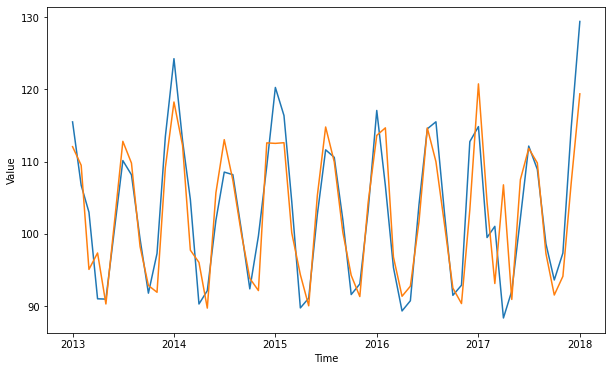

In [19]:
# Plot the comparisons between actual values and estimated values
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, LSTM_results)

# Accuracy
LSTM_MAE = tf.keras.metrics.mean_absolute_error(x_valid, LSTM_results).numpy()
LSTM_MAE

<Figure size 432x288 with 0 Axes>

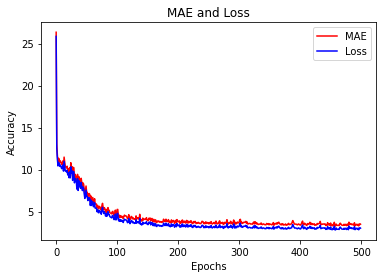

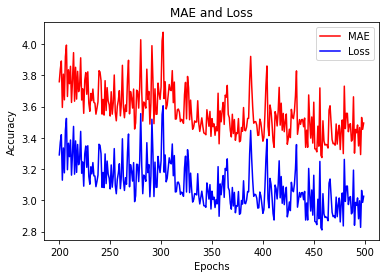

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Interpretation

In [21]:
MAE_table = pd.DataFrame({"Model": ["Prophet", "SNN", "DNN", "LSTM"], 
             "MAE": [prophet_MAE, SNN_MAE, DNN_MAE, LSTM_MAE]})
MAE_table

,Model,MAE
0,Prophet,3.315252
1,SNN,3.192224
2,DNN,5.188700
3,LSTM,3.697444
